In [1]:
cd '/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_three/dw_matrix_road_sign'

/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_three/dw_matrix_road_sign


In [38]:
import pandas as pd
import numpy as np

import os
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

%load_ext tensorboard

import matplotlib.pyplot as plt
from skimage import color, exposure

from sklearn.metrics import accuracy_score

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
train = pd.read_pickle('data/train.p')
test = pd.read_pickle('data/test.p')

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [4]:
y_train

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

In [5]:
len(np.unique(y_train))

43

In [0]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)

In [7]:
y_train.shape, y_test.shape 

((34799, 43), (4410, 43))

In [0]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [9]:
model = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
  
  Flatten(),

  Dense(num_classes, activation='softmax'),
])

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 43)                2476843   
Total params: 2,478,635
Trainable params: 2,478,635
Non-trainable params: 0
_________________________________________________________________
1088/1088 [==============================] - 3s 3ms/step - loss: 9.8802 - accuracy: 0.7956


In [0]:
def get_cnn_v1(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    
    Flatten(),

    Dense(num_classes, activation='softmax'),
  ])

def train_model(model, X_train, y_train, params_fit={}):
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

  model.fit(
      X_train, 
      y_train,
      batch_size=params_fit.get('batch_size', 128),
      epochs=params_fit.get('epochs', 5),
      verbose=params_fit.get('verbose', 1),
      validation_data=params_fit.get('validation_data', (X_train, y_train)),
      callbacks=[tensorboard_callback]
  )

  return model


In [13]:
model = get_cnn_v1(input_shape, num_classes)
model_trained = train_model(model, X_train, y_train)

Epoch 1/5
272/272 [==============================] - 2s 9ms/step - loss: 27.8628 - accuracy: 0.7244 - val_loss: 0.2736 - val_accuracy: 0.9359
Epoch 2/5
272/272 [==============================] - 2s 8ms/step - loss: 0.2327 - accuracy: 0.9471 - val_loss: 0.1189 - val_accuracy: 0.9729
Epoch 3/5
272/272 [==============================] - 2s 9ms/step - loss: 0.1263 - accuracy: 0.9707 - val_loss: 0.1207 - val_accuracy: 0.9730
Epoch 4/5
272/272 [==============================] - 2s 9ms/step - loss: 0.1239 - accuracy: 0.9722 - val_loss: 0.1176 - val_accuracy: 0.9732
Epoch 5/5
272/272 [==============================] - 2s 9ms/step - loss: 0.1043 - accuracy: 0.9766 - val_loss: 0.0715 - val_accuracy: 0.9830


In [0]:
df = pd.read_csv('data/signnames.csv')
labels_dict = df.to_dict()['b']

In [0]:
def predict(model_trained, X_test, y_test, scoring=accuracy_score):

  y_test_norm = np.argmax(y_test, axis=1)

  y_pred_prob = model_trained.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)

  return scoring(y_test_norm, y_pred)


In [50]:
 predict(model_trained, X_test, y_test)

0.8283446712018141

In [0]:
def train_and_predict(model):
  model_trained = train_model(model, X_train, y_train)
  return predict(model_trained, X_test, y_test)

In [51]:
def get_cnn_v2(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax'),x
  ])


train_and_predict( get_cnn_v2(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 3s 9ms/step - loss: 4.8130 - accuracy: 0.2733 - val_loss: 1.6277 - val_accuracy: 0.5570
Epoch 2/5
272/272 [==============================] - 2s 9ms/step - loss: 1.4101 - accuracy: 0.5826 - val_loss: 0.5493 - val_accuracy: 0.8731
Epoch 3/5
272/272 [==============================] - 2s 9ms/step - loss: 0.6892 - accuracy: 0.7940 - val_loss: 0.2027 - val_accuracy: 0.9582
Epoch 4/5
272/272 [==============================] - 2s 9ms/step - loss: 0.4020 - accuracy: 0.8792 - val_loss: 0.1239 - val_accuracy: 0.9777
Epoch 5/5
272/272 [==============================] - 2s 9ms/step - loss: 0.3024 - accuracy: 0.9098 - val_loss: 0.0787 - val_accuracy: 0.9794


0.9126984126984127

In [52]:
def get_cnn_v3(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax'),
  ])


train_and_predict( get_cnn_v3(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 3s 12ms/step - loss: 2.7112 - accuracy: 0.4282 - val_loss: 0.5680 - val_accuracy: 0.8473
Epoch 2/5
272/272 [==============================] - 3s 11ms/step - loss: 0.7355 - accuracy: 0.7788 - val_loss: 0.2303 - val_accuracy: 0.9560
Epoch 3/5
272/272 [==============================] - 3s 11ms/step - loss: 0.3641 - accuracy: 0.8937 - val_loss: 0.0860 - val_accuracy: 0.9776
Epoch 4/5
272/272 [==============================] - 3s 11ms/step - loss: 0.2247 - accuracy: 0.9325 - val_loss: 0.0361 - val_accuracy: 0.9926
Epoch 5/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1596 - accuracy: 0.9524 - val_loss: 0.0308 - val_accuracy: 0.9920


0.9666666666666667

In [55]:
def get_cnn_v4(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax'),
  ])

train_and_predict( get_cnn_v4(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 4s 13ms/step - loss: 2.7040 - accuracy: 0.2681 - val_loss: 1.3431 - val_accuracy: 0.5560
Epoch 2/5
272/272 [==============================] - 3s 12ms/step - loss: 1.1971 - accuracy: 0.6141 - val_loss: 0.3746 - val_accuracy: 0.8958
Epoch 3/5
272/272 [==============================] - 3s 12ms/step - loss: 0.5303 - accuracy: 0.8350 - val_loss: 0.1353 - val_accuracy: 0.9620
Epoch 4/5
272/272 [==============================] - 3s 13ms/step - loss: 0.3061 - accuracy: 0.9063 - val_loss: 0.0669 - val_accuracy: 0.9803
Epoch 5/5
272/272 [==============================] - 3s 13ms/step - loss: 0.2154 - accuracy: 0.9355 - val_loss: 0.0417 - val_accuracy: 0.9889


0.9800453514739229

In [56]:
def get_cnn_v5(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax'),
  ])

train_and_predict( get_cnn_v5(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 4s 14ms/step - loss: 2.5722 - accuracy: 0.2720 - val_loss: 1.2998 - val_accuracy: 0.5508
Epoch 2/5
272/272 [==============================] - 4s 13ms/step - loss: 1.0726 - accuracy: 0.6509 - val_loss: 0.3552 - val_accuracy: 0.8863
Epoch 3/5
272/272 [==============================] - 4s 13ms/step - loss: 0.5078 - accuracy: 0.8352 - val_loss: 0.1271 - val_accuracy: 0.9629
Epoch 4/5
272/272 [==============================] - 4s 13ms/step - loss: 0.3154 - accuracy: 0.9014 - val_loss: 0.0693 - val_accuracy: 0.9794
Epoch 5/5
272/272 [==============================] - 4s 13ms/step - loss: 0.2215 - accuracy: 0.9324 - val_loss: 0.0469 - val_accuracy: 0.9871


0.9605442176870749

In [57]:
X_train[0].shape

(32, 32, 3)

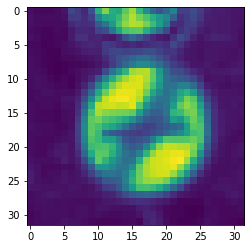

In [59]:
plt.imshow( color.rgb2gray( X_train[0] ) )

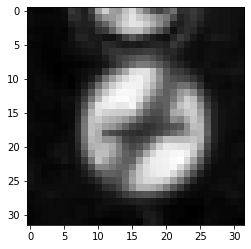

In [60]:
plt.imshow( color.rgb2gray( X_train[0] ), cmap=plt.get_cmap('gray') )

In [0]:
X_train_gray = color.rgb2gray( X_train ).reshape(-1, 32, 32, 1)
X_test_gray = color.rgb2gray( X_test ).reshape(-1, 32, 32, 1)
input_shape_gray =  X_train_gray.shape[1:]

In [66]:
X_train_gray.shape

(34799, 32, 32, 1)

In [71]:
model = get_cnn_v5(input_shape_gray, num_classes)
model_trained = train_model(model, X_train_gray, y_train, params_fit={})
predict(model_trained, X_test_gray, y_test)


Epoch 1/5
272/272 [==============================] - 4s 14ms/step - loss: 2.3437 - accuracy: 0.3272 - val_loss: 0.6581 - val_accuracy: 0.7904
Epoch 2/5
272/272 [==============================] - 4s 13ms/step - loss: 0.5195 - accuracy: 0.8297 - val_loss: 0.1361 - val_accuracy: 0.9576
Epoch 3/5
272/272 [==============================] - 4s 13ms/step - loss: 0.2153 - accuracy: 0.9316 - val_loss: 0.0553 - val_accuracy: 0.9841
Epoch 4/5
272/272 [==============================] - 4s 13ms/step - loss: 0.1473 - accuracy: 0.9546 - val_loss: 0.0280 - val_accuracy: 0.9929
Epoch 5/5
272/272 [==============================] - 4s 13ms/step - loss: 0.1094 - accuracy: 0.9661 - val_loss: 0.0181 - val_accuracy: 0.9951


0.9693877551020408

In [0]:
def preproc_img(img):
  hsv = color.rgb2hsv(img)
  hsv[:, :, 2] = exposure.equalize_adapthist(hsv[:, :, 2])
  img = color.hsv2rgb(hsv)

  return img

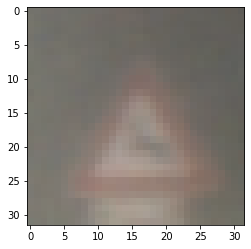

In [73]:
plt.imshow(X_train[400])

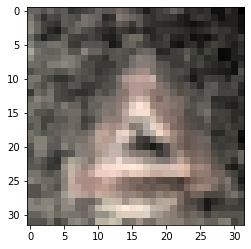

In [76]:
plt.imshow( preproc_img(X_train[400]) )

data augmentation  
https://github.com/joshwadd/Deep-traffic-sign-classification